In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import time
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

%matplotlib inline 

In [4]:
Data = pd.read_csv("vehicles.csv")

In [5]:
Used_Cars = Data.copy()

In [6]:
Used_Cars.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [7]:
Used_Cars.shape

(426880, 26)

In [8]:
Used_Cars.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [9]:
Used_Cars = Used_Cars.drop(columns=['id','url', 'region_url', 'VIN','image_url','description','county', 'lat', 'long', 'size', 'state'], axis = 1)

In [10]:
Used_Cars = Used_Cars.drop_duplicates()

In [11]:
Used_Cars.isnull().sum()/Used_Cars.shape[0]*100

region           0.000000
price            0.000000
year             0.279729
manufacturer     4.131515
model            1.233715
condition       40.783336
cylinders       41.620650
fuel             0.703306
odometer         1.028252
title_status     1.926010
transmission     0.596241
drive           30.585159
type            21.752128
paint_color     30.498710
posting_date     0.013354
dtype: float64

In [12]:
Used_Cars.dropna(inplace = True)
# Used_Cars.dropna(subset = ['year', 'odometer', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission'], inplace = True)
# Used_Cars.fillna('unknown', inplace=True)
# Used_Cars.shape

In [13]:
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
Used_Cars.describe(percentiles).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
price,115983.0,60675.723899,1.146592e+07,0.0,0.0,5736.0,10995.0,22900.0,55000.00,3.736929e+09
year,115983.0,2009.556952,9.596126e+00,1900.0,1967.0,2006.0,2012.0,2015.0,2020.00,2.022000e+03
odometer,115983.0,111928.133804,2.198430e+05,0.0,200.0,55630.0,102725.0,147654.0,283058.32,1.000000e+07


In [14]:
Used_Cars.describe(include = "object").T

,count,unique,top,freq
region,115983,403,vermont,1390
manufacturer,115983,41,ford,20740
model,115983,11529,f-150,1872
condition,115983,6,excellent,52252
cylinders,115983,8,6 cylinders,43100
fuel,115983,5,gas,106179
title_status,115983,6,clean,109887
transmission,115983,3,automatic,95507
drive,115983,3,4wd,49081
type,115983,13,sedan,30951


In [15]:
manufacturer_values = Used_Cars['manufacturer'].value_counts()
Used_Cars['manufacturer'] = Used_Cars['manufacturer'].apply(lambda x: x if str(x) in manufacturer_values[:20] else 'others')

In [16]:
region_values = Used_Cars['region'].value_counts()
Used_Cars['region'] = Used_Cars['region'].apply(lambda x: x if str(x) in region_values[:50] else 'others')

In [17]:
model_values = Used_Cars['model'].value_counts()
Used_Cars['model'] = Used_Cars['model'].apply(lambda x: x if str(x) in model_values[:50] else 'others')

<AxesSubplot:ylabel='price'>

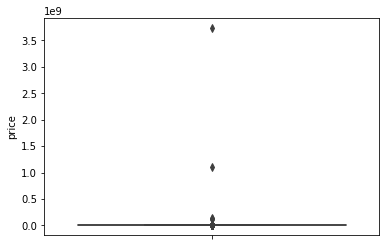

In [18]:
sns.boxplot(data=Used_Cars, y="price")

<AxesSubplot:ylabel='price'>

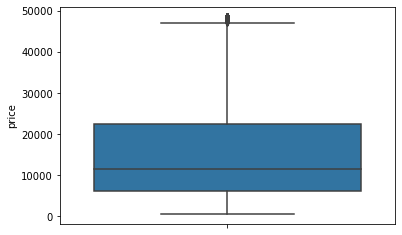

In [19]:
Q1,Q3 = np.percentile(Used_Cars["price"],[25,75])
IQR = Q3-Q1
UL = Q3+1.5*IQR
LL = Q1-1.5*IQR
#print(UL,LL)
Used_Cars = Used_Cars.drop(Used_Cars[(Used_Cars.price<500) | (Used_Cars.price>UL)].index)
sns.boxplot(data=Used_Cars, y="price")

<AxesSubplot:xlabel='price', ylabel='Count'>

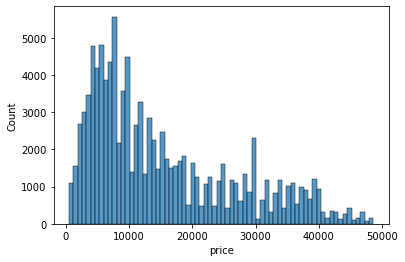

In [20]:
sns.histplot(data = Used_Cars, x = 'price')

<AxesSubplot:ylabel='odometer'>

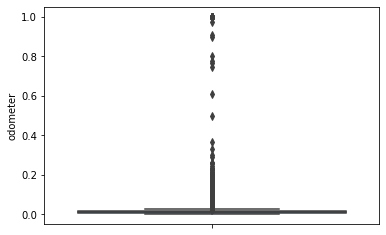

In [21]:
scaler = MinMaxScaler()
Used_Cars[['odometer']] = scaler.fit_transform(Used_Cars[['odometer']])
sns.boxplot(data=Used_Cars, y="odometer")

<AxesSubplot:ylabel='odometer'>

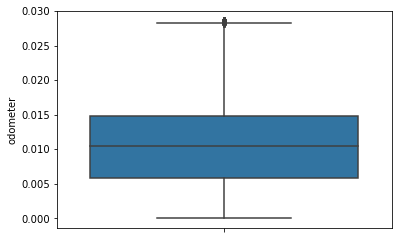

In [22]:
Q1,Q3 = np.percentile(Used_Cars["odometer"],[25,75])
IQR = Q3-Q1
UL = Q3+1.5*IQR
LL = Q1-1.5*IQR
#print(UL,LL)
Used_Cars = Used_Cars.drop(Used_Cars[(Used_Cars.odometer<0) | (Used_Cars.odometer>UL)].index)
sns.boxplot(data=Used_Cars, y="odometer")

<AxesSubplot:xlabel='odometer', ylabel='Count'>

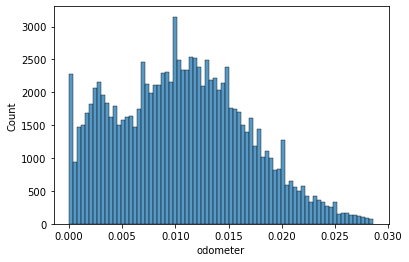

In [23]:
sns.histplot(data = Used_Cars, x = 'odometer')

             price      year  odometer
price     1.000000  0.369841 -0.593774
year      0.369841  1.000000 -0.256805
odometer -0.593774 -0.256805  1.000000


<AxesSubplot:>

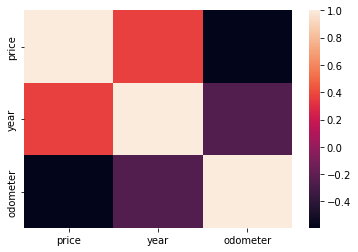

In [24]:
print(Used_Cars.corr())
sns.heatmap(Used_Cars.corr())

In [25]:
Used_Cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,posting_date
31,others,15000,2013.0,ford,others,excellent,6 cylinders,gas,0.01280,clean,automatic,rwd,truck,black,2021-05-03T14:02:03-0500
32,others,27990,2012.0,gmc,others,good,8 cylinders,gas,0.00687,clean,other,4wd,pickup,black,2021-05-03T13:41:25-0500
33,others,34590,2016.0,chevrolet,others,good,6 cylinders,gas,0.00295,clean,other,4wd,pickup,silver,2021-05-03T12:41:33-0500
34,others,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,0.00430,clean,automatic,4wd,truck,grey,2021-05-03T12:12:59-0500
35,others,29990,2016.0,chevrolet,others,good,6 cylinders,gas,0.00173,clean,other,4wd,pickup,red,2021-05-03T11:31:14-0500


In [26]:
Used_Cars[['posting_date','posting_time']] = (Used_Cars['posting_date'].str.split("T", expand=True))

In [27]:
Used_Cars['posting_date'] = pd.to_datetime(Used_Cars['posting_date'], format="%Y/%m/%d")
#Used_Cars['posting_date']=Used_Cars['posting_date'].map(dt.datetime.toordinal)
Used_Cars['car_age'] = Used_Cars['posting_date'].dt.year - Used_Cars['year']
scaler = MinMaxScaler()
Used_Cars[['car_age']] = scaler.fit_transform(Used_Cars[['car_age']])
Used_Cars[['year']] = scaler.fit_transform(Used_Cars[['year']])
Used_Cars[['year']] = Used_Cars[['year']].astype(int)

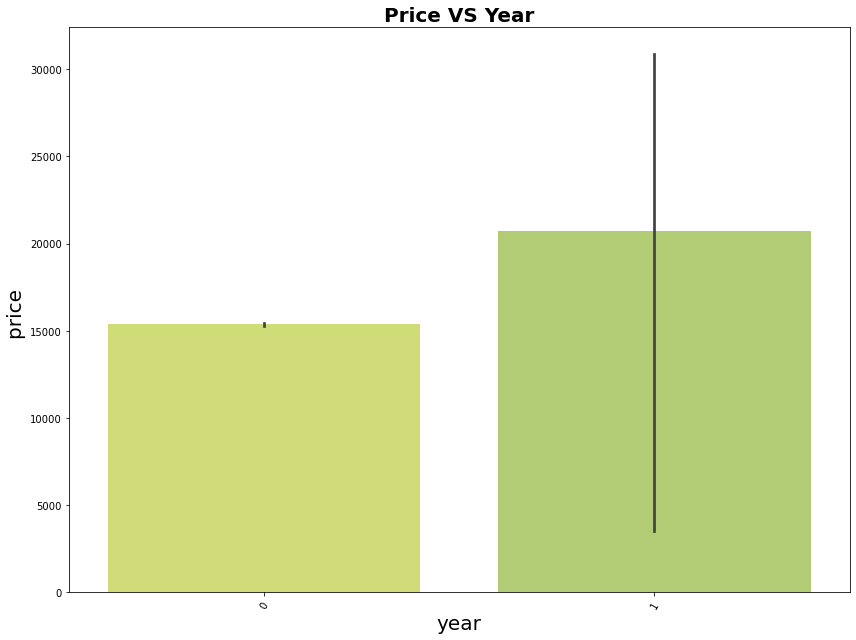

In [28]:
plt.rcParams["figure.autolayout"] = True
sns.set_palette('summer_r')
plt.figure(figsize =(12,9))
sns.barplot(y=Used_Cars['price'],x=Used_Cars['year'])
plt.title("Price VS Year",fontsize=20,fontweight ='bold')
plt.xlabel('year',fontsize = 20)
plt.xticks(rotation=60)
plt.ylabel('price ',fontsize = 20)
plt.tight_layout()
plt.show()

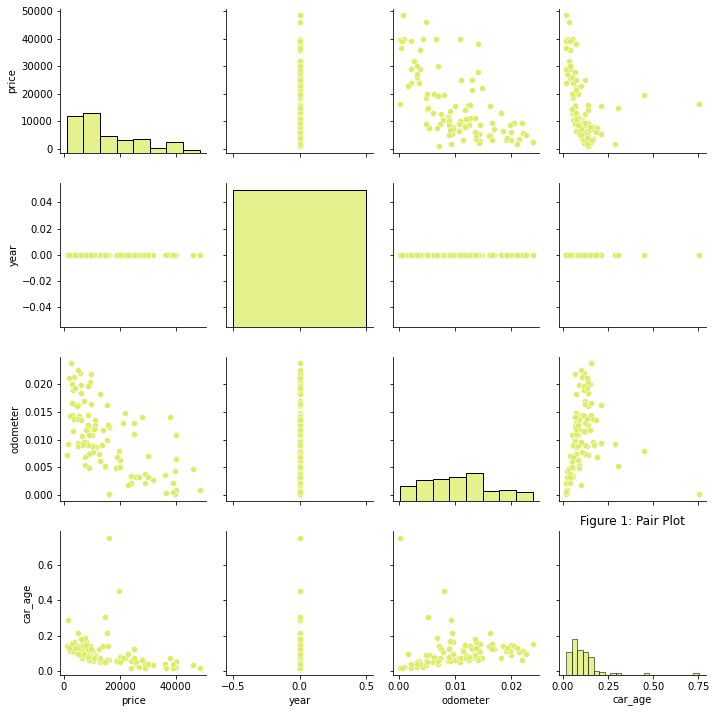

In [29]:
sns.pairplot(Used_Cars.sample(100))
plt.title('Figure 1: Pair Plot')
plt.tight_layout()
plt.savefig('Insight-Pair-Plot',dpi=None)
plt.show()

In [30]:
Used_Cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,posting_date,posting_time,car_age
31,others,15000,0,ford,others,excellent,6 cylinders,gas,0.01280,clean,automatic,rwd,truck,black,2021-05-03,14:02:03-0500,0.073770
32,others,27990,0,gmc,others,good,8 cylinders,gas,0.00687,clean,other,4wd,pickup,black,2021-05-03,13:41:25-0500,0.081967
33,others,34590,0,chevrolet,others,good,6 cylinders,gas,0.00295,clean,other,4wd,pickup,silver,2021-05-03,12:41:33-0500,0.049180
34,others,35000,0,toyota,tacoma,excellent,6 cylinders,gas,0.00430,clean,automatic,4wd,truck,grey,2021-05-03,12:12:59-0500,0.024590
35,others,29990,0,chevrolet,others,good,6 cylinders,gas,0.00173,clean,other,4wd,pickup,red,2021-05-03,11:31:14-0500,0.049180


C:\Users\gauta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


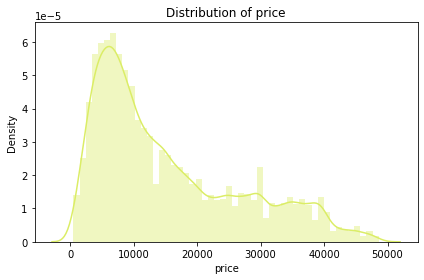

In [31]:
sns.distplot(Used_Cars.price)
plt.tight_layout()
plt.title("Distribution of price")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()

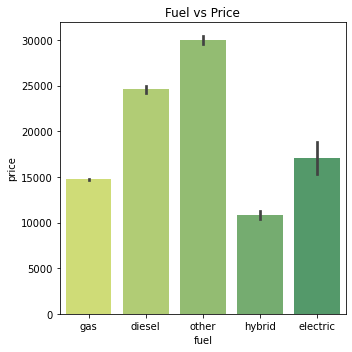

In [32]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='fuel',y='price',data=Used_Cars,ax=axs)
axs.set_title('Fuel vs Price')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

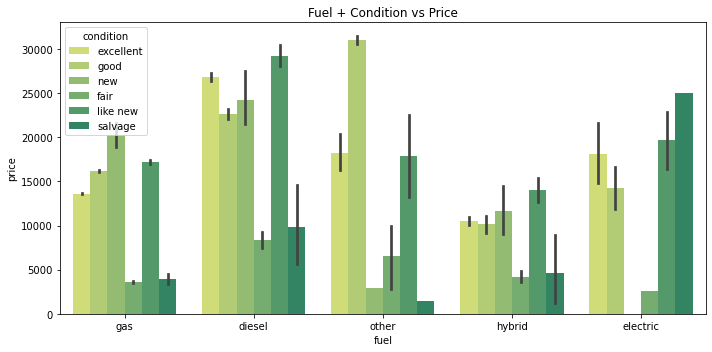

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=Used_Cars)
plt.title('Fuel + Condition vs Price')
plt.savefig('Insight-Figure-2',dpi=None)
plt.show()

In [34]:
enc = OrdinalEncoder(categories = [[ 'salvage', 'fair', 'unknown', 'good', 'excellent', 'like new', 'new']])
Used_Cars[['condition']]=enc.fit_transform(Used_Cars[['condition']])

In [35]:
Used_Cars.info()
cols = ['region', 'manufacturer', 'model',
       'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'type', 'paint_color']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106694 entries, 31 to 426878
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   region        106694 non-null  object        
 1   price         106694 non-null  int64         
 2   year          106694 non-null  int32         
 3   manufacturer  106694 non-null  object        
 4   model         106694 non-null  object        
 5   condition     106694 non-null  float64       
 6   cylinders     106694 non-null  object        
 7   fuel          106694 non-null  object        
 8   odometer      106694 non-null  float64       
 9   title_status  106694 non-null  object        
 10  transmission  106694 non-null  object        
 11  drive         106694 non-null  object        
 12  type          106694 non-null  object        
 13  paint_color   106694 non-null  object        
 14  posting_date  106694 non-null  datetime64[ns]
 15  posting_time  10

In [36]:
df_encoded = pd.get_dummies(Used_Cars, columns=cols, drop_first=True)
Used_Cars=df_encoded
Used_Cars.columns

Index(['price', 'year', 'condition', 'odometer', 'posting_date',
       'posting_time', 'car_age', 'region_albany', 'region_albuquerque',
       'region_anchorage / mat-su',
       ...
       'paint_color_brown', 'paint_color_custom', 'paint_color_green',
       'paint_color_grey', 'paint_color_orange', 'paint_color_purple',
       'paint_color_red', 'paint_color_silver', 'paint_color_white',
       'paint_color_yellow'],
      dtype='object', length=170)

In [37]:
Used_Cars_Price = Used_Cars['price']
Used_Cars_features = Used_Cars.drop(columns=['price','posting_time','posting_date'], axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Used_Cars_features, Used_Cars_Price, test_size = 0.3, 
                                                    random_state = 42)
Score_Data = {}

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)
Coefficients = {}
for i in range(len(Used_Cars_features.columns)):
    Coefficients[Used_Cars_features.columns[i]]=model.coef_[i]
print("Coefficients = ",Coefficients)
print("Intercept:",model.intercept_)

Coefficients =  {'year': 6639.180673058936, 'condition': 1029.335081572111, 'odometer': -850549.2623164215, 'car_age': -37725.86084707193, 'region_albany': -1004.2415971493265, 'region_albuquerque': -847.3170250408123, 'region_anchorage / mat-su': 2182.7290987281312, 'region_atlanta': -330.2103383430331, 'region_boise': 20.252702513173062, 'region_boston': -2801.637280858209, 'region_central NJ': -2076.1756613519283, 'region_charlotte': -513.8300960809484, 'region_cincinnati': -992.6907769225695, 'region_cleveland': -2335.613557064794, 'region_columbus': -3027.356794541931, 'region_dallas / fort worth': -732.3965526653956, 'region_des moines': -642.9700057304394, 'region_detroit metro': -2093.035580780861, 'region_ft myers / SW florida': -710.9108395193198, 'region_grand rapids': 552.994590039958, 'region_greenville / upstate': 66.74660287519964, 'region_indianapolis': -949.7332687363623, 'region_jacksonville': 125.00855707631126, 'region_kansas city, MO': -763.5271398620098, 'region_l

In [39]:
print("Training R-Score for Linear Regression =", model.score(X_train, y_train))
print("Test R-Score for Linear Regression =", model.score(X_test, y_test))
Score_Data["Linear Regression"]=model.score(X_test, y_test)*100

Training R-Score for Linear Regression = 0.7218734278159047
Test R-Score for Linear Regression = 0.7156934521122715


In [40]:
cnt_pred_train = model.predict(X_train)
cnt_pred_test = model.predict(X_test)

In [41]:
e_train = y_train - cnt_pred_train
e_perc_train = (y_train - cnt_pred_train)/y_train
MAE_train = np.mean(np.abs(e_train))
MAPE_train = np.mean(np.abs(e_perc_train))
e_test = y_test - cnt_pred_test 
e_perc_test = (y_test - cnt_pred_test)/y_test
MAE_test = np.mean(np.abs(e_test))
MAPE_test = np.mean(np.abs(e_perc_test))
print("Linear Regression MAE_train =",MAE_train)
print("Linear Regression MAE_test =",MAE_test)

Linear Regression MAE_train = 4377.681452202071
Linear Regression MAE_test = 4403.960968698165


In [42]:
param_poly = {  'polynomialfeatures__degree'  : [1,2,3]  }
pipe_poly = PolynomialFeatures()
pipe_lr = LinearRegression()
pipe_poly_reg = make_pipeline(pipe_poly , pipe_lr)
grid_poly = GridSearchCV(pipe_poly_reg , param_poly, cv = 5)
grid_poly

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [1]})

In [43]:
start_time = time.time()
grid_poly.fit(X_train, y_train)
print((time.time()-start_time)/60, " minutes")

0.178639554977417  minutes


In [44]:
print("Training R-Score for Polynomial Regression =", grid_poly.best_estimator_.score(X_train, y_train))
print("Test R-Score for Polynomial Regression =", grid_poly.best_estimator_.score(X_test, y_test))
Score_Data["Polynomial Regression"]=grid_poly.best_estimator_.score(X_test, y_test)*100

Training R-Score for Polynomial Regression = 0.7218734278159047
Test R-Score for Polynomial Regression = 0.7156934521122719


In [45]:
cnt_Poly_pred_train = grid_poly.predict(X_train)
cnt_Poly_pred_test = grid_poly.predict(X_test)
e_Poly_train = y_train - cnt_Poly_pred_train
e_Poly_perc_train = (y_train - cnt_Poly_pred_train)/y_train
MAE_Poly_train = np.mean(np.abs(e_Poly_train))
MAPE_Poly_train = np.mean(np.abs(e_Poly_perc_train))
e_Poly_test = y_test - cnt_Poly_pred_test 
e_Poly_perc_test = (y_test - cnt_Poly_pred_test)/y_test
MAE_Poly_test = np.mean(np.abs(e_Poly_test))
MAPE_Poly_test = np.mean(np.abs(e_Poly_perc_test))
print("Poly Regression MAE_train =",MAE_Poly_train)
print("Poly Regression MAE_test =",MAE_Poly_test)

Poly Regression MAE_train = 4377.68145220199
Poly Regression MAE_test = 4403.960968698044


In [46]:
# 1. Define a list of parameters (key is 'alpha')
lasso_params = {  'alpha' :  [0.001, 0.01, 0.1, 1, 10] }
# 2. Define function and fit the data
lasso = Lasso(max_iter=10000)
grid_lasso = GridSearchCV(lasso, lasso_params, cv = 5)

In [47]:
start_time = time.time()
grid_lasso.fit(X_train, y_train)
print((time.time()-start_time)/60, " minutes")
## 3.1b performance based on which optimal hyperparameter is chosen:
print(grid_lasso.best_score_)
# 3.2 find best hyperparameters
print(grid_lasso.best_params_)
# 3.3 find best parameter estimates: coef and intercept of chosen model
grid_lasso.best_estimator_.coef_, grid_lasso.best_estimator_.intercept_

13.482408281167348  minutes
0.7204532149827911
{'alpha': 0.01}


(array([ 5.89257095e+03,  1.03010709e+03, -8.50166197e+05, -3.77277586e+04,
        -9.48690159e+02, -7.92484573e+02,  2.23716312e+03, -2.74805255e+02,
         7.20949157e+01, -2.74645761e+03, -2.02053132e+03, -4.58700309e+02,
        -9.37270007e+02, -2.28064296e+03, -2.97320424e+03, -6.77612923e+02,
        -5.88055692e+02, -2.03801059e+03, -6.55829805e+02,  6.05223482e+02,
         1.19073311e+02, -8.94860371e+02,  1.77593069e+02, -7.07745615e+02,
        -2.50834793e+03, -1.46238843e+03, -7.13088321e+02, -7.26325133e+01,
        -1.31708777e+03, -1.80242205e+03, -1.04043053e+03,  1.25961517e+03,
        -2.09213828e+03, -3.46889788e+03, -1.88474577e+03, -1.09763008e+03,
        -3.32394006e+01, -8.56367386e+02, -2.87214198e+03, -5.44238087e+02,
        -1.77692005e+03, -1.17566684e+03, -1.64091196e+02, -2.52593435e+03,
        -2.00796574e+03, -8.22103787e+02, -1.69108097e+03, -2.41180641e+03,
         1.16478238e+03, -1.45150947e+03, -1.01596209e+02, -1.59028441e+03,
        -1.1

In [48]:
# 3.1 Present performance measure
## 3.1a unbiased performance in R2
print("Training R-Score for Lasso Regression =", grid_lasso.best_estimator_.score(X_train, y_train))
print("Test R-Score for Lasso Regression =", grid_lasso.best_estimator_.score(X_test, y_test))
Score_Data["Lasso Regression"]=grid_lasso.best_estimator_.score(X_test, y_test)*100

Training R-Score for Lasso Regression = 0.7218728406324012
Test R-Score for Lasso Regression = 0.7156994741095725


In [49]:
cnt_pred_lasso_train = grid_lasso.predict(X_train)
cnt_pred_lasso_test = grid_lasso.predict(X_test)
e_lasso_train = y_train - cnt_pred_lasso_train
e_lasso_perc_train = (y_train - cnt_pred_lasso_train)/y_train
MAE_lasso_train = np.mean(np.abs(e_lasso_train))
MAPE_lasso_train = np.mean(np.abs(e_lasso_perc_train))
e_lasso_test = y_test - cnt_pred_lasso_test 
e_lasso_perc_test = (y_test - cnt_pred_lasso_test)/y_test
MAE_lasso_test = np.mean(np.abs(e_lasso_test))
MAPE_lasso_test = np.mean(np.abs(e_lasso_perc_test))
print("Lasso Regression MAE_train =",MAE_lasso_train)
print("Lasso Regression MAE_test =",MAE_lasso_test)

Lasso Regression MAE_train = 4377.540831959163
Lasso Regression MAE_test = 4403.841178862306


In [50]:
ridge_params = {  'alpha' :  [0.001, 0.01, 0.1, 1, 10,100]  }
# 2. Define function and fit the data
ridge = Ridge(max)
grid_ridge = GridSearchCV(ridge, ridge_params, cv = 5)
grid_ridge.fit(X_train, y_train)
# 3.1 Present performance measure
## 3.1a unbiased performance in R2
print(grid_ridge.score(X_test, y_test))
## 3.1b performance based on which optimal hyperparameter is chosen:
print(grid_ridge.best_score_)
# 3.2 find best hyperparameters
print(grid_ridge.best_params_)
# 3.3 find best parameter estimates: coef and intercept of chosen model
grid_ridge.best_estimator_.coef_, grid_ridge.best_estimator_.intercept_

0.715692249133786
0.7204526583964954
{'alpha': 0.001}


(array([ 6.63637504e+03,  1.03008786e+03, -8.50086458e+05, -3.77312415e+04,
        -1.00382755e+03, -8.47201304e+02,  2.18426902e+03, -3.30952988e+02,
         2.01944765e+01, -2.80176650e+03, -2.07611732e+03, -5.14129467e+02,
        -9.93132496e+02, -2.33569622e+03, -3.02775109e+03, -7.32958891e+02,
        -6.42938541e+02, -2.09338243e+03, -7.10608548e+02,  5.52922073e+02,
         6.64455012e+01, -9.50117103e+02,  1.24604913e+02, -7.64250481e+02,
        -2.56334849e+03, -1.51749379e+03, -7.68821696e+02, -1.26783066e+02,
        -1.37223671e+03, -1.85791366e+03, -1.09539060e+03,  1.20684700e+03,
        -2.14735412e+03, -3.52343175e+03, -1.94032082e+03, -1.15236411e+03,
        -8.85984933e+01, -9.10294297e+02, -2.92721424e+03, -5.99421331e+02,
        -1.83159814e+03, -1.23040427e+03, -2.17958141e+02, -2.58110293e+03,
        -2.06290438e+03, -8.77012915e+02, -1.74584550e+03, -2.46743452e+03,
         1.11204795e+03, -1.50755711e+03, -1.57189647e+02, -1.64531613e+03,
        -1.2

In [51]:
print("Training R-Score for Ridge Regression =", grid_ridge.best_estimator_.score(X_train, y_train))
print("Test R-Score for Ridge Regression =", grid_ridge.best_estimator_.score(X_test, y_test))
Score_Data["Ridge Regression"]=grid_ridge.best_estimator_.score(X_test, y_test)*100

Training R-Score for Ridge Regression = 0.7218733877360695
Test R-Score for Ridge Regression = 0.715692249133786


In [52]:
cnt_ridge_pred_train = grid_ridge.predict(X_train)
cnt_ridge_pred_test = grid_ridge.predict(X_test)
e_ridge_train = y_train - cnt_ridge_pred_train
e_ridge_perc_train = (y_train - cnt_ridge_pred_train)/y_train
MAE_ridge_train = np.mean(np.abs(e_ridge_train))
MAPE_ridge_train = np.mean(np.abs(e_ridge_perc_train))
e_ridge_test = y_test - cnt_ridge_pred_test 
e_ridge_perc_test = (y_test - cnt_ridge_pred_test)/y_test
MAE_ridge_test = np.mean(np.abs(e_ridge_test))
MAPE_ridge_test = np.mean(np.abs(e_ridge_perc_test))
print("Ridge Regression MAE_train =",MAE_ridge_train)
print("Ridge Regression MAE_test =",MAE_ridge_test)

Ridge Regression MAE_train = 4377.569690521768
Ridge Regression MAE_test = 4403.873427902204


In [74]:
knn = KNeighborsRegressor()

# define a list of parameters
param_knn = {'n_neighbors': range(3, 10, 1)}  

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv = 5)
grid_knn.fit(X_train, y_train)

# the best hyperparameter chosen:
print(grid_knn.best_params_)

# When k=25 (best case), the validation score of through CV is:
print(grid_knn.best_score_)

print(grid_knn.score(X_test, y_test))

{'n_neighbors': 5}
0.770117921079984
0.7756202188097463


In [54]:
print("Training R-Score for KNN Regression =", grid_knn.score(X_train, y_train))
print("Test R-Score for KNN Regression =", grid_knn.score(X_test, y_test))
Score_Data["KNN Regression"]=grid_knn.score(X_test, y_test)*100

Training R-Score for KNN Regression = 0.8581859323600671
Test R-Score for KNN Regression = 0.7756202188097463


In [55]:
cnt_KNN_pred_train = grid_knn.predict(X_train)
cnt_KNN_pred_test = grid_knn.predict(X_test)
e_KNN_train = y_train - cnt_KNN_pred_train
e_KNN_perc_train = (y_train - cnt_KNN_pred_train)/y_train
MAE_KNN_train = np.mean(np.abs(e_KNN_train))
MAPE_KNN_train = np.mean(np.abs(e_KNN_perc_train))
e_KNN_test = y_test - cnt_KNN_pred_test 
e_KNN_perc_test = (y_test - cnt_KNN_pred_test)/y_test
MAE_KNN_test = np.mean(np.abs(e_KNN_test))
MAPE_KNN_test = np.mean(np.abs(e_KNN_perc_test))
print("KNN Regression MAE_train =",MAE_KNN_train)
print("KNN Regression MAE_test =",MAE_KNN_test)

KNN Regression MAE_train = 2683.882086094946
KNN Regression MAE_test = 3400.458289855926


In [78]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, max_features=0.33)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9181890278934215

In [79]:
print("Training R-Score for Random Forest Regression =", rf.score(X_train, y_train))
print("Test R-Score for Random Forest Regression =", rf.score(X_test, y_test))
Score_Data["Random Forest Regression"]=rf.score(X_test, y_test)*100

Training R-Score for Random Forest Regression = 0.988442317080318
Test R-Score for Random Forest Regression = 0.9181890278934215


In [80]:
cnt_rf_pred_train = rf.predict(X_train)
cnt_rf_pred_test = rf.predict(X_test)
e_rf_train = y_train - cnt_rf_pred_train
e_rf_perc_train = (y_train - cnt_rf_pred_train)/y_train
MAE_rf_train = np.mean(np.abs(e_rf_train))
MAPE_rf_train = np.mean(np.abs(e_rf_perc_train))
e_rf_test = y_test - cnt_rf_pred_test 
e_rf_perc_test = (y_test - cnt_rf_pred_test)/y_test
MAE_rf_test = np.mean(np.abs(e_rf_test))
MAPE_rf_test = np.mean(np.abs(e_rf_perc_test))
print("Random Forest Regression MAE_train =",MAE_rf_train)
print("Random Forest Regression MAE_test =",MAE_rf_test)

Random Forest Regression MAE_train = 690.7311142830532
Random Forest Regression MAE_test = 1829.567450856381


In [59]:
from sklearn.model_selection import GridSearchCV

opt_tree = DecisionTreeRegressor(random_state = 0)

dt_params = {'max_depth':  range(1,8) ,        
             'min_samples_split':   range(20,300,20)}

grid_tree = GridSearchCV(opt_tree, dt_params)
grid_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': range(1, 8),
                         'min_samples_split': range(20, 300, 20)})

In [60]:
print("Training R-Score for Decision Tree Regression =", grid_tree.best_estimator_.score(X_train, y_train))
print("Test R-Score for Decision Tree Regression =", grid_tree.best_estimator_.score(X_test, y_test))
Score_Data["Decision Tree Regression"]=grid_tree.best_estimator_.score(X_test, y_test)*100

Training R-Score for Decision Tree Regression = 0.7874043353263163
Test R-Score for Decision Tree Regression = 0.7811149207645692


In [61]:
grid_tree.best_params_

{'max_depth': 7, 'min_samples_split': 40}

In [62]:
cnt_DT_pred_train = grid_tree.predict(X_train)
cnt_DT_pred_test = grid_tree.predict(X_test)
e_DT_train = y_train - cnt_DT_pred_train
e_DT_perc_train = (y_train - cnt_DT_pred_train)/y_train
MAE_DT_train = np.mean(np.abs(e_DT_train))
MAPE_DT_train = np.mean(np.abs(e_DT_perc_train))
e_DT_test = y_test - cnt_DT_pred_test 
e_DT_perc_test = (y_test - cnt_DT_pred_test)/y_test
MAE_DT_test = np.mean(np.abs(e_DT_test))
MAPE_DT_test = np.mean(np.abs(e_DT_perc_test))
print("DT Regression MAE_train =",MAE_DT_train)
print("DT Regression MAE_test =",MAE_DT_test)

DT Regression MAE_train = 3700.220379288685
DT Regression MAE_test = 3718.8843157481742


In [81]:
ABR = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
ABR.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  n_estimators=100)

In [82]:
print("Training R-Score for AdaBoost Regression =", ABR.score(X_train, y_train))
print("Test R-Score for AdaBoost Regression =", ABR.score(X_test, y_test))
Score_Data["AdaBoost Regression"]=ABR.score(X_test, y_test)*100

Training R-Score for AdaBoost Regression = 0.7634498838161421
Test R-Score for AdaBoost Regression = 0.7392852235902363


In [65]:
cnt_ABR_pred_train = ABR.predict(X_train)
cnt_ABR_pred_test = ABR.predict(X_test)
e_ABR_train = y_train - cnt_ABR_pred_train
e_ABR_perc_train = (y_train - cnt_ABR_pred_train)/y_train
MAE_ABR_train = np.mean(np.abs(e_ABR_train))
MAPE_ABR_train = np.mean(np.abs(e_ABR_perc_train))
e_ABR_test = y_test - cnt_ABR_pred_test 
e_ABR_perc_test = (y_test - cnt_ABR_pred_test)/y_test
MAE_ABR_test = np.mean(np.abs(e_ABR_test))
MAPE_ABR_test = np.mean(np.abs(e_ABR_perc_test))
print("AdaBoost Regression MAE_train =",MAE_ABR_train)
print("AdaBoost Regression MAE_test =",MAE_ABR_test)

AdaBoost Regression MAE_train = 2983.3161116976253
AdaBoost Regression MAE_test = 3118.0778888719674


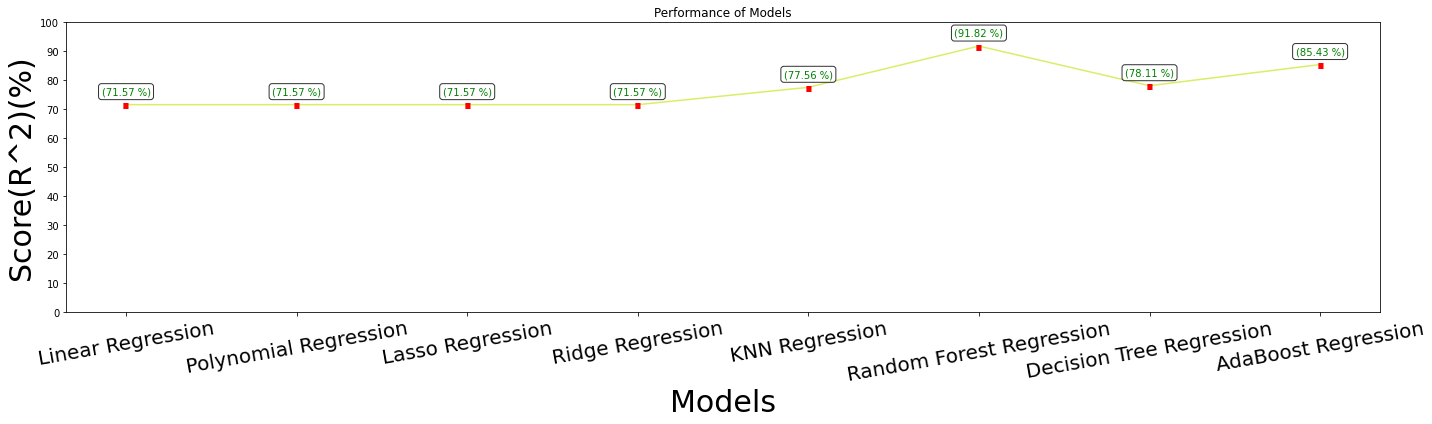

In [66]:
x=list(range(len(Score_Data)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(Score_Data.keys(),Score_Data.values())
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Score(R^2)(%)",fontsize=30)
plt.title("Performance of Models")
for k in Score_Data.keys():
    b=Score_Data[k]
    val="("+str(round(b,2))+" %)"
    plt.text(k, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(k, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show()